In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection

from typing import Tuple

plt.style.use('ggplot')

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
df = pd.read_excel("/content/data.xls", skiprows=4)
df = df.dropna()
df.rename(columns={'Unnamed: 0': 'Регион'}, inplace=True)
df.set_index('Регион', inplace=True)
df

,январь,февраль,март,апрель,май,июнь,июль,август,сентябрь,октябрь,...,январь.2,февраль.2,март.2,апрель.2,май.2,июнь.2,июль.2,август.2,сентябрь.2,октябрь.2
Регион,,,,,,,,,,,,,,,,,,,,,
Центральный федеральный округ,1.619,0.955,1.058,0.963,0.871,1.213,1.036,1.312,1.351,0.958,...,0.379,0.739,0.679,0.658,0.402,0.789,0.877,0.880,1.160,1.275
Московская область,0.710,0.480,0.140,0.261,0.286,0.472,0.187,0.436,0.207,0.339,...,0.016,0.208,0.076,0.159,0.061,0.283,0.196,0.185,0.379,0.222
Ленинградская область,0.231,0.053,0.091,0.168,0.072,0.100,0.084,0.024,0.111,0.058,...,0.104,0.044,0.082,0.055,0.101,0.049,0.143,0.132,0.180,0.065


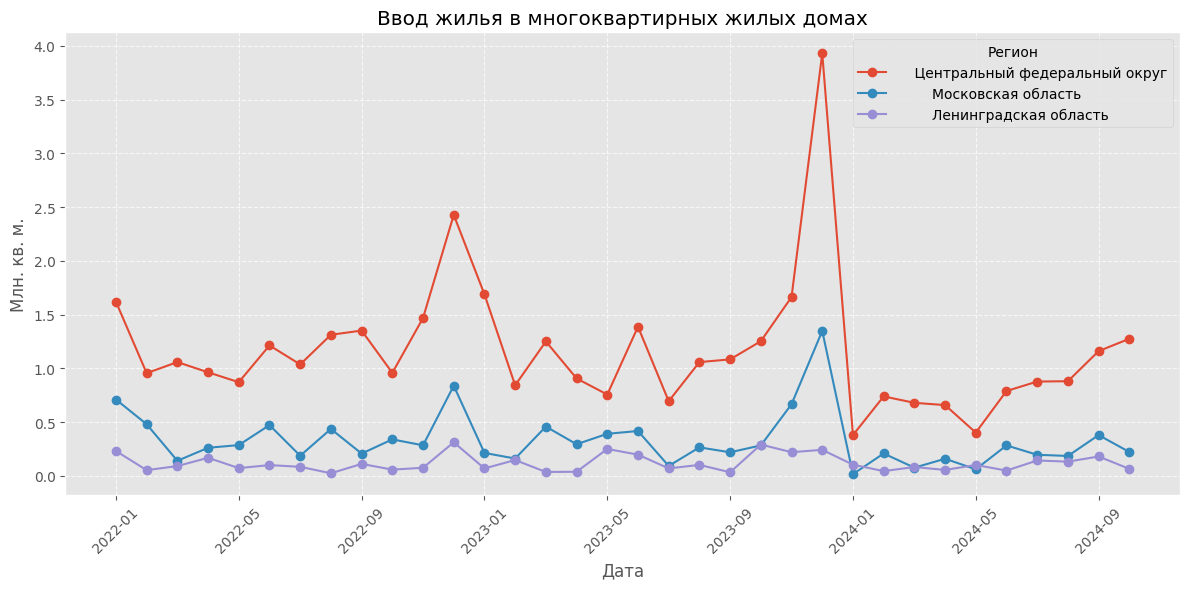

<Figure size 640x480 with 0 Axes>

In [5]:
# df.set_index('Регион', inplace=True)
month_columns = pd.date_range(start='2022-01-01', end='2024-10-01', freq='MS').strftime('%Y-%m').tolist()

# построение графика
plt.figure(figsize=(12, 6))

# построение графика для каждого региона
for region in df.index:
    plt.plot(month_columns, df.loc[region], marker='o', label=region)

plt.title('Ввод жилья в многоквартирных жилых домах')
plt.xlabel('Дата')
plt.ylabel('Млн. кв. м.')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Регион')
plt.tight_layout()
plt.show()

## FUNCTIONS

In [10]:
def holt_winters_forecasting(time_series: np.ndarray,
                             smoothing_level: float,
                             smoothing_trend: float,
                             smoothing_seasonal: float,
                             season_length: int,
                             forecast_periods: int = 1) -> Tuple:
    """
    Функция прогнозирования ряда методом Хольта-Уинтерса.

    :param time_series: np.ndarray - входной временной ряд;
    :param smoothing_level: float - параметр сглаживания (alpha);
    :param smoothing_trend: float - параметр сглаживания тренда (beta);
    :param smoothing_seasonal: float - параметр сглаживания сезонности (gamma);
    :param season_length: int - длина сезона;
    :param forecast_periods: int - количество периодов для прогноза.

    :return: tuple - кортеж, содержащий прогноз на forecast_periods периодов вперед, параметры модели.
    """
    # Инициализация компонентов модели
    n = len(time_series)
    seasonals = np.zeros(season_length)
    level = time_series[0]
    trend = 0.0
    forecast = []

    # Инициализация сезонных компонентов
    for i in range(season_length):
        seasonals[i] = time_series[i] - level

    # Основной цикл по временным рядам
    for t in range(1, n + forecast_periods):
        if t < n:
            last_level = level
            level = smoothing_level * (time_series[t] - seasonals[t % season_length]) + (1 - smoothing_level) * (level + trend)
            trend = smoothing_trend * (level - last_level) + (1 - smoothing_trend) * trend
            seasonals[t % season_length] = smoothing_seasonal * (time_series[t] - level) + (1 - smoothing_seasonal) * seasonals[t % season_length]

        # Прогнозирование
        if t >= n:
            forecast.append(level + trend * (t - n + 1) + seasonals[t % season_length])

    return forecast[-forecast_periods:], (level, trend, seasonals[-1])



def tune_hyperparameters(time_series: np.ndarray,
                         season_length=12,
                         forecast_periods: int = 1) -> Tuple:
    """
    Функция для подбора оптимальных гиперпараметров модели Хольта-Уинтерса.

    :param time_series: np.ndarray - входной временной ряд;
    :param forecast_periods: int - количество периодов для прогноза.

    :return: tuple - кортеж, содержащий лучший прогноз и параметры.
    """
    param_grid = {
        'smoothing_level': np.linspace(0.01, 1, 10),
        'smoothing_trend': np.linspace(0.01, 1, 10),
        'smoothing_seasonal': np.linspace(0.01, 1, 10)
    }

    best_score = np.inf
    best_params = None
    best_forecast = None

    for smoothing_level in param_grid['smoothing_level']:
        for smoothing_trend in param_grid['smoothing_trend']:
            for smoothing_seasonal in param_grid['smoothing_seasonal']:
                forecast, _ = holt_winters_forecasting(
                    time_series, smoothing_level, smoothing_trend, smoothing_seasonal, season_length, forecast_periods
                )
                error = mean_absolute_error(time_series[-forecast_periods:], forecast)

                if error < best_score:
                    best_score = error
                    best_params = (smoothing_level, smoothing_trend, smoothing_seasonal)
                    best_forecast = forecast

    return best_forecast, best_params


In [11]:
def taking_region(region_name: str) -> pd.DataFrame:
  """
    Функция для отображения выбранного региона

    :param region_name: str - название региона

    :returns pd.DataFrame - датафрейм, содержащий только выбранный регион
  """
  df_region = df[df.index.str.contains(region_name)]
  month_region = pd.date_range(start='2022-01-01', end='2024-10-01', freq='MS').strftime('%Y-%m').tolist()
  df_region.columns = month_region

  return df_region


def make_plot(years: np.ndarray,
              values: np.ndarray,
              label: str,
              flag_forecast: bool=False,
              best_forecast: np.ndarray=None,
              years_forecast: np.ndarray=None) -> None:
  """
    Функция для отображения графика введения жилья в многоквартирных жилых домах
    для выбранного региона. Дополнительно выводит прогноз

    :param years: np.ndarray - массив дат, для которых имеются данные;
    :param values: np.ndarray - массив значений;
    :param label: str - метка для графика, указывающая, какой регион или категория данных отображается;
    :param flag_forecast: bool, optional - флаг, указывающий, нужно ли отображать прогноз;
    :param best_forecast: np.ndarray, optional - прогнозные значения;
    :param years_forecast: np.ndarray, optional - массив дат для прогноза.

    :returns: None - функция выводит график
  """
  plt.figure(figsize=(10, 5))
  plt.plot(years, values, marker='o', label=label, color='#859bc6')

  # добавление прогноза, если указан флаг
  if flag_forecast:
    plt.plot(years_forecast, best_forecast, label='Forecast', color='#c6859b', marker='x', markersize=10)

  plt.title('Ввод жилья в многоквартирных жилых домах')
  plt.xlabel('Дата')
  plt.ylabel('Млн. кв. м.')
  plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
  plt.xticks(rotation=45)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
  plt.tight_layout()
  plt.show()


def write_info(df: pd.DataFrame,
               best_forecast: np.ndarray,
               dt: str,
               best_params: tuple) -> None:
  """
  Функция для вывода информации о прогнозах, ошибках и параметрах модели.

    :param df: pd.DataFrame - исходный DataFrame с данными;
    :param best_forecast: np.ndarray - прогнозируемые значения, где последний элемент представляет прогноз для последнего периода;
    :param dt: str - название региона, для которого производится прогноз;
    :param best_params: tuple - лучшие параметры модели

    :returns: None - функция выводит информацию.
  """
  last_value_by_index = df.iloc[-1].values[-1]
  print(f"\nForecast value: {best_forecast[-1]:.2f}, true value: {last_value_by_index}\ndelta = {(best_forecast[-1]-last_value_by_index):.2f}")

  # общий вывод
  print("\n" + "=" * 100)
  print(f"\nRegion: {dt}")
  print(f"Best model params: {best_params}")
  print(f"Forecast: {best_forecast[-1]:.2f}\n")
  print("=" * 100 + "\n")

## МОСКОВСКАЯ ОБЛАСТЬ

In [12]:
df_moscow = taking_region('Московская область')
df_moscow

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10
Регион,,,,,,,,,,,,,,,,,,,,,
Московская область,0.71,0.48,0.14,0.261,0.286,0.472,0.187,0.436,0.207,0.339,...,0.016,0.208,0.076,0.159,0.061,0.283,0.196,0.185,0.379,0.222


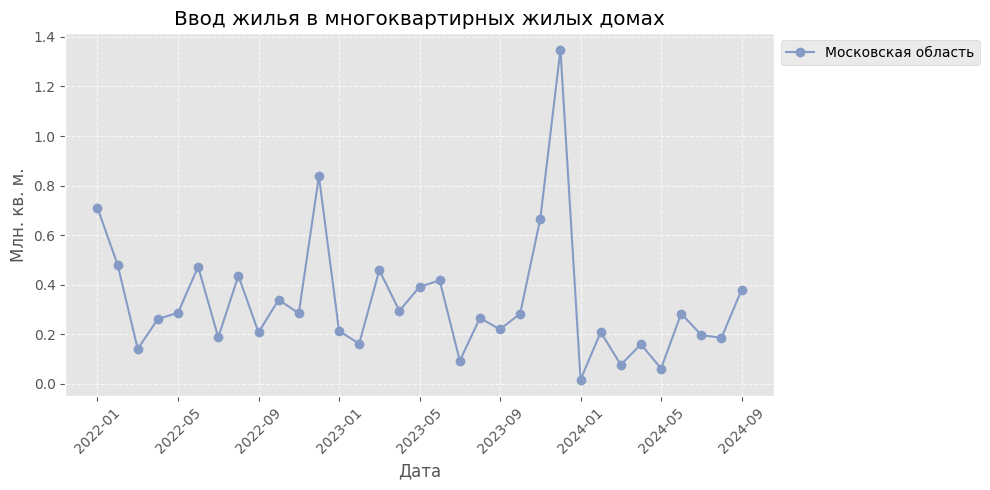

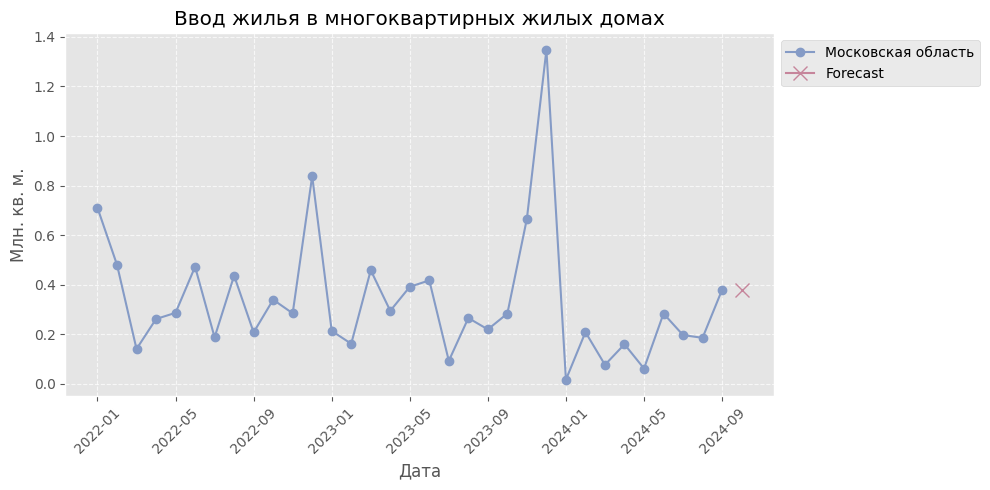


Forecast value: 0.38, true value: 0.222
delta = 0.16


Region:         Московская область
Best model params: (0.45, 0.34, 0.45)
Forecast: 0.38




In [14]:
# список дат для обучения модели, исключая последний месяц (период для прогнозирования)
filtered_date_moscow = month_columns[:len(month_columns) - 1]

# отбор данных для таргентного региона до последнего месяца
df_filtered_moscow = df_moscow[filtered_date_moscow]

# извлечение значений столбцов из отфильтрованного датафрейма
years = df_filtered_moscow.columns.values

# извлечение значения для региона из датафрейма
values = df_filtered_moscow.values[0]
region_name = 'Московская область'

make_plot(years, values, region_name)

# выполнение прогноза для текущего временного ряда
for dt in df_filtered_moscow.index:
  time_series = df_filtered_moscow.loc[dt].values

  # поиск оптимальных гиперпараметров для модели Хольта-Уинтерса
  best_forecast, best_params = tune_hyperparameters(time_series)

  # извлечение последнего года из списка дат
  last_year = int(filtered_date_moscow[-1][:4])

  # вычисление следующего года, на который нужно сделать прогноз
  next_year = last_year + 1

  # создание строки с датой для октября следующего года (для использования в графике)
  next_year_date = str(next_year) + '-10'

  # объединение списока filtered_date_moscow с датой следующего года для отображения прогноза
  years = np.concatenate((filtered_date_moscow, [next_year_date]))

  make_plot(years=filtered_date_moscow,
            values=time_series,
            label=region_name,
            flag_forecast=True,
            best_forecast=best_forecast,
            years_forecast=years[-1:])

  write_info(df=df_moscow,
             best_forecast=best_forecast,
             dt=dt,
             best_params=best_params)

## ЛЕНИНГРАДСКАЯ ОБЛАСТЬ

In [15]:
df_SPB = taking_region('Ленинградская область')
df_SPB

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10
Регион,,,,,,,,,,,,,,,,,,,,,
Ленинградская область,0.231,0.053,0.091,0.168,0.072,0.1,0.084,0.024,0.111,0.058,...,0.104,0.044,0.082,0.055,0.101,0.049,0.143,0.132,0.18,0.065


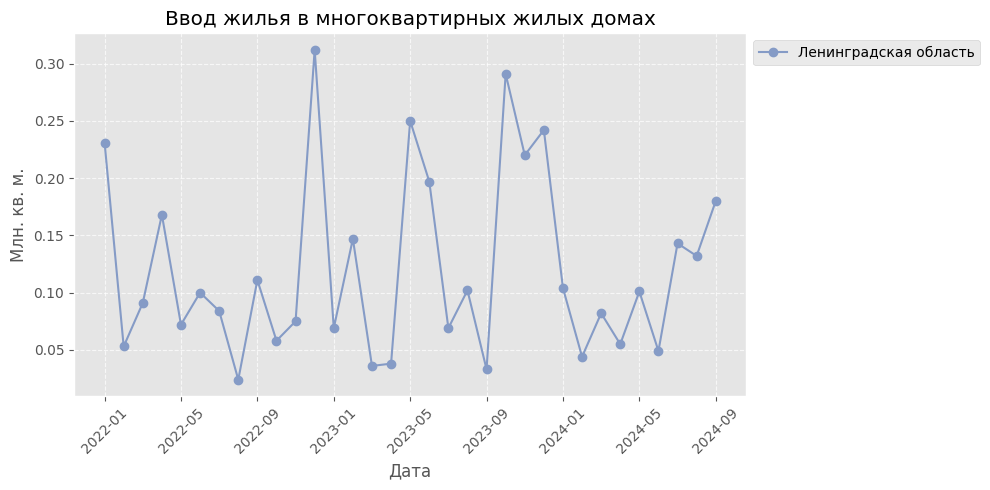

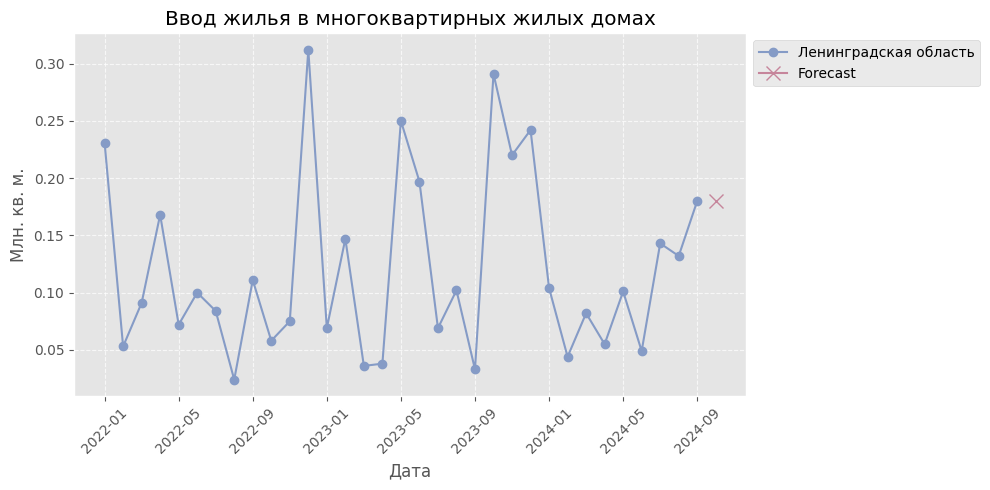


Forecast value: 0.18, true value: 0.065
delta = 0.12


Region:         Ленинградская область
Best model params: (0.12, 0.34, 0.67)
Forecast: 0.18




In [16]:
filtered_date_SPB = month_columns[:len(month_columns) - 1]
df_filtered_SPB = df_SPB[filtered_date_SPB]

years = df_filtered_SPB.columns.values
values = df_filtered_SPB.values[0]

region_name = 'Ленинградская область'

make_plot(years, values, region_name)

for dt in df_filtered_SPB.index:
  time_series = df_filtered_SPB.loc[dt].values
  best_forecast, best_params = tune_hyperparameters(time_series)
  last_year = int(filtered_date_SPB[-1][:4])
  next_year = last_year + 1
  next_year_date = str(next_year) + '-10'
  years = np.concatenate((filtered_date_SPB, [next_year_date]))

  make_plot(years=filtered_date_SPB,
            values=time_series,
            label=region_name,
            flag_forecast=True,
            best_forecast=best_forecast,
            years_forecast=years[-1:])

  write_info(df=df_SPB,
             best_forecast=best_forecast,
             dt=dt,
             best_params=best_params)

## ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ

In [17]:
df_central = taking_region('Центральный федеральный округ')
df_central

,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10
Регион,,,,,,,,,,,,,,,,,,,,,
Центральный федеральный округ,1.619,0.955,1.058,0.963,0.871,1.213,1.036,1.312,1.351,0.958,...,0.379,0.739,0.679,0.658,0.402,0.789,0.877,0.88,1.16,1.275


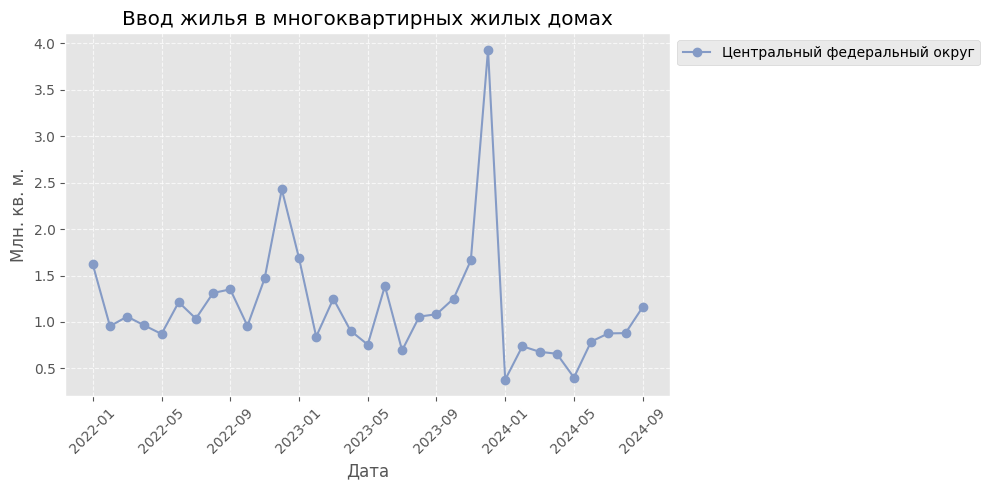

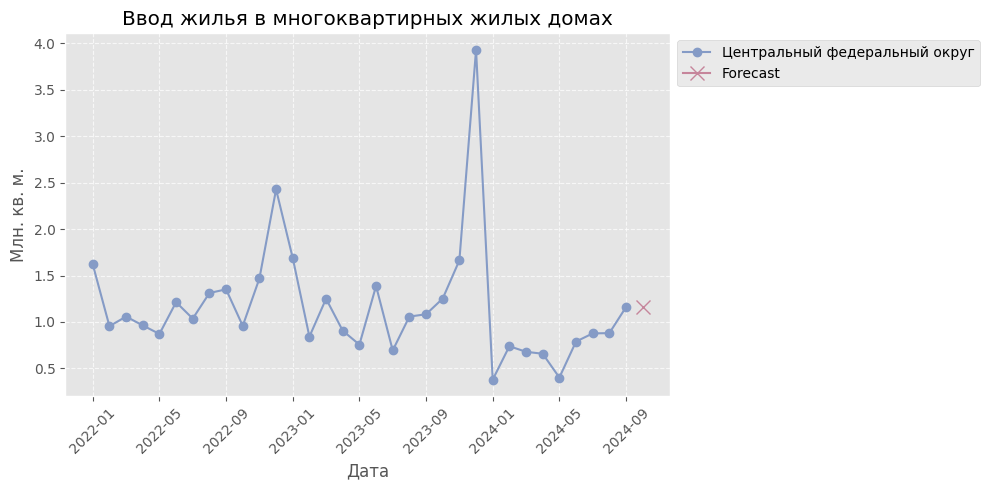


Forecast value: 1.16, true value: 1.275
delta = -0.11


Region:     Центральный федеральный округ
Best model params: (0.01, 0.12, 0.78)
Forecast: 1.16




In [18]:
filtered_date_central = month_columns[:len(month_columns) - 1]
df_filtered_central = df_central[filtered_date_central]

years = df_filtered_central.columns.values
values = df_filtered_central.values[0]

region_name = 'Центральный федеральный округ'

make_plot(years, values, region_name)

for dt in df_filtered_central.index:
  time_series = df_filtered_central.loc[dt].values
  best_forecast, best_params = tune_hyperparameters(time_series)
  last_year = int(filtered_date_central[-1][:4])
  next_year = last_year + 1
  next_year_date = str(next_year) + '-10'
  years = np.concatenate((filtered_date_central, [next_year_date]))

  make_plot(years=filtered_date_central,
            values=time_series,
            label=region_name,
            flag_forecast=True,
            best_forecast=best_forecast,
            years_forecast=years[-1:])

  write_info(df=df_central,
             best_forecast=best_forecast,
             dt=dt,
             best_params=best_params)

## HOLT MODEL FOR DISEASE DATASET

In [ ]:
def holt_winters_forecasting(time_series:  np.ndarray,
                             smoothing_level: float,
                             smoothing_trend: float,
                             smoothing_seasonal: float,
                             season_length: int,
                             forecast_periods: int = 1) -> Tuple:
  """
    Функция прогнозирования ряда методом Хольта-Уинтерса.

    :param time_series: np.ndarray - входной временной ряд;
    :param smoothing_level: float - gараметр сглаживания (alpha). Значение от 0 до 1. Чем ближе к 1, тем больше вес последних наблюдений;
    :param smoothing_trend: float - параметр сглаживания тренда (beta). Значение от 0 до 1. Чем ближе к 1, тем больше вес последних изменений тренда;
    :param smoothing_seasonal: Параметр сглаживания сезонности (gamma). Значение от 0 до 1. Чем ближе к 1, тем больше вес последних сезонных колебаний;
    :param season_length: int - длина сезона;
    :param forecast_periods: int - кол-во периодов, на которые нужно сделать прогноз.

    :return: tuple - кортеж, содержащий обученную модель экспоненциального сглаживания,
                    прогноз на forecast_periods периодов вперед, параметры обученной модели.

  """
  # создание модели экспоненциального сглаживания Хольта-Уинтерса
  model = ExponentialSmoothing(
      time_series, # входной временной ряд, представленный в виде массива NumPy
      trend='add', # аддитивный тренд
      seasonal='add', # сезонность не учитывается
      seasonal_periods=season_length
  )

  # обучение моделт на входных данных
  fitted_model = model.fit(smoothing_level=smoothing_level,
                           smoothing_trend=smoothing_trend,
                           smoothing_seasonal=smoothing_seasonal)

  # прогнозирование
  forecast = fitted_model.forecast(forecast_periods)

  return fitted_model, forecast, fitted_model.params



def tune_hyperparameters(time_series: np.ndarray,
                         season_length=12,
                         forecast_periods: int =1) -> Tuple:
  """
    Функция для подбора оптимальных гиперпараметров модели Хольта-Уинтерса

    :param time_series: np.ndarray - входной временной ряд;
    :param forecast_periods: int - кол-во периодов, на которые нужно сделать прогноз.

    :return: tuple - кортеж, содержащий лучшую обученную модель, лучший прогноз, параметры обученной модели.

  """
  # устанавливка диапазонов гиперпараметров для сглаживания
  param_grid = {
      'smoothing_level': np.linspace(0.001, 1, 10),
      'smoothing_trend': np.linspace(0.001, 1, 10),
      'smoothing_seasonal': np.linspace(0.001, 1, 10)
  }

  best_score = np.inf  # лучшая ошибка [inf]
  best_params = None   # лучшие параметры [None]
  best_model = None    # лучшая модель [None]
  best_forecast = None # лучший прогноз [None]

  # поиск лучших параметров
  for smoothing_level in param_grid['smoothing_level']:
    for smoothing_trend in param_grid['smoothing_trend']:
      for smoothing_seasonal in param_grid['smoothing_seasonal']:

        # прогноз с текущими параметрами
        model, forecast, params = holt_winters_forecasting(
            time_series, smoothing_level, smoothing_trend, smoothing_seasonal, season_length, forecast_periods
        )

        # оценка ошибки прогноза
        error = mean_absolute_error(time_series[-forecast_periods:], forecast)

        # обновление параметров
        if error < best_score:
          best_score = error
          best_params = (smoothing_level, smoothing_trend, smoothing_seasonal)
          best_model = model
          best_forecast = forecast

  return best_model, best_forecast, best_params

,Наименование заболеваний,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2,активный туберкулез,130.7,119.2,117.6,118.4,120.8,117.2,109.9,104.3,97.5,90.4,59.3,84.5,78.1,70.9,65.2,60.5,47.4,45.4,45.6
3,сахарный диабет,162.0,249.5,289.0,302.4,301.6,308.6,324.0,318.9,343.3,339.5,343.0,352.2,339.4,363.5,369.6,410.5,321.8,346.0,373.4
4,"болезни, характеризующиеся повышенным кровяным...",434.8,772.6,1007.3,990.3,979.0,920.3,870.7,848.3,841.3,885.0,1010.2,1315.1,1399.4,1418.9,1538.6,1727.0,1368.0,1447.5,1718.1
6,сифилис,239.4,97.9,93.1,89.6,85.0,75.7,63.7,53.8,47.3,41.5,36.6,34.4,31.1,28.6,24.6,22.0,15.3,21.2,27.8
7,гонококковая инфекция,175.9,101.8,91.0,86.4,80.1,68.2,60.6,54.5,52.0,42.7,34.3,27.1,21.1,16.3,12.8,11.2,9.8,10.8,11.9
8,трихомоноз,462.9,305.9,284.8,264.8,237.9,205.3,180.0,159.2,1334.5,117.6,102.2,92.1,81.3,70.5,62.8,54.9,38.8,36.0,33.3
10,злокачественные новообразования,427.5,442.9,448.3,455.5,458.1,469.8,479.5,481.6,480.0,484.4,510.5,524.3,530.5,540.9,542.6,552.2,471.5,490.6,523.7
12,психические расстройства и расстройства поведения,121.0,95.9,92.3,84.8,78.5,77.5,74.3,70.3,68.2,65.1,64.4,62.8,60.1,59.3,59.1,58.7,50.5,53.7,58.7
14,острый вирусный гепатит В2),62.0,12.4,10.1,7.5,5.7,3.8,3.2,2.4,2.0,1.9,1.9,1.6,1.4,1.3,1.0,0.8,0.5,0.5,0.4
15,острый вирусный гепатит С2),30.8,6.4,5.9,5.1,4.0,3.2,3.0,2.6,2.2,2.1,2.2,2.1,1.8,1.8,1.6,1.5,1.0,0.9,1.1


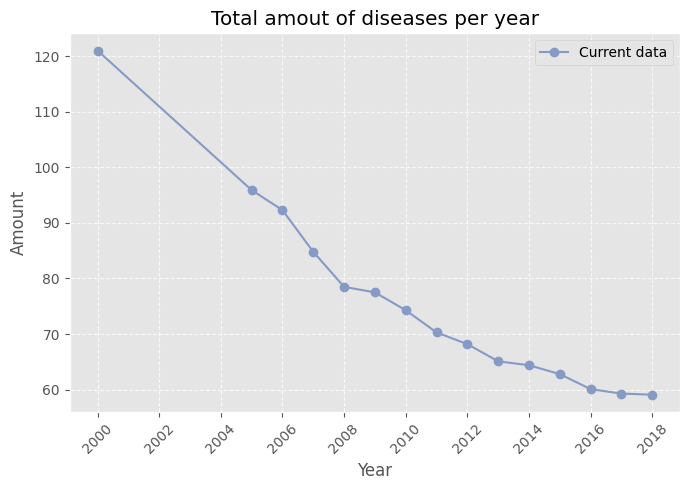

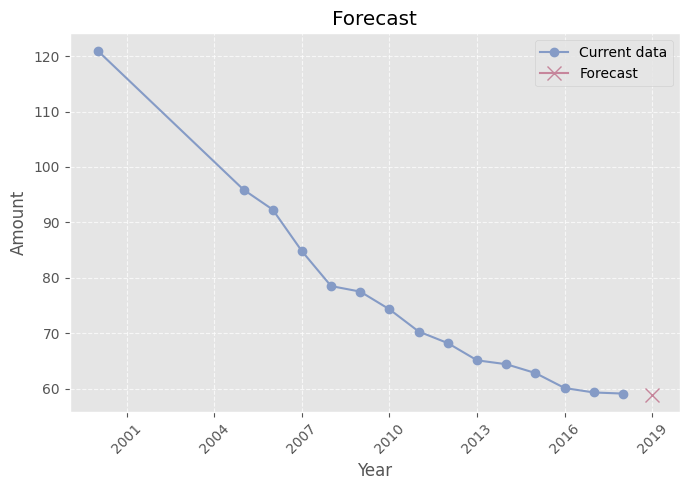


Forecast value: 58.90, true value: 58.7
delta = 0.20


Disease: психические расстройства и расстройства поведения
Best model params: (1.0, 1.0)
Forecast: 58.90




In [ ]:
if __name__ == '__main__':
    # загрузка данных из файла
    df = pd.read_excel("/content/zdr2-2.xls", skiprows=4, nrows=17)
    df = df.dropna()
    df.rename(columns = {'2022 4)': 2022}, inplace=True)

    # преобразование данных в числовой формат
    df.iloc[:, 1:] = df.iloc[:, 1:].replace(',', '.', regex=True).astype(float)
    display(df)
    print("\n")

    # фильтрация данных по таргету
    df_psycho = df[df['Наименование заболеваний'] == 'психические расстройства и расстройства поведения']
    df_psycho.set_index('Наименование заболеваний', inplace=True)

    filtered_years = [year for year in years if year <= 2018]  # оставляю только данные до 2018 года, чтобы потом сравнить предсказание
    df_psycho = df_psycho[filtered_years]
    years = df_psycho.columns.values
    values = df_psycho.values[0]

    # построение графика по истинным значениям
    plt.figure(figsize=(7, 5))
    plt.plot(years, values, marker='o', label='Current data', color='#859bc6')
    plt.title('Total amout of diseases per year')
    plt.xlabel('Year')
    plt.ylabel('Amount')
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # прогнозирование количества заболеваний для таргета
    for disease in df_psycho.index:
        time_series = df_psycho.loc[disease].values

        # тюнинг гиперпараметров
        best_model, best_forecast, best_params = tune_hyperparameters(time_series, forecast_periods=1)

        years = np.concatenate((filtered_years, [filtered_years[-1] + 1]))  # добавляю следующий год для прогноза

        # построение графика с предсказанием
        plt.figure(figsize=(7, 5))
        plt.plot(filtered_years, time_series, label='Current data', color='#859bc6', marker='o')
        plt.plot(years[-1:], best_forecast, label='Forecast', color='#c6859b', marker='x', markersize=10)
        plt.title(f'Forecast')
        plt.xlabel('Year')
        plt.ylabel('Amount')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(years)
        plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # сохранение истинного значения на момент 2019 года, который предсказывала модель
        value_2019 = df[2019][12]
        print(f"\nForecast value: {best_forecast[-1]:.2f}, true value: {value_2019}\ndelta = {(best_forecast[-1]-value_2019):.2f}")

        # общий вывод
        print("\n" + "=" * 100)
        print(f"\nDisease: {disease}")
        print(f"Best model params: {best_params}")
        print(f"Forecast: {best_forecast[-1]:.2f}\n")
        print("=" * 100 + "\n")